# Training on CIFAR-10 and evaluating on CIFAR-10C

Credit: https://juliusruseckas.github.io/ml/fast-resnet.html

In [1]:
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from tqdm import tqdm

from myrtlenet import Net

## Setup

In [2]:
DATA_DIR = '/mnt/ssd/ronak/datasets/cifar10'

NUM_CLASSES = 10
NUM_WORKERS = 8
BATCH_SIZE = 512
EPOCHS = 20
LEARNING_RATE = 1e-2
WEIGHT_DECAY = 1e-2

DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("device:", DEVICE)

device: cuda


## Data

In [3]:
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.RandomErasing(p=0.1)
])

train_dset = datasets.CIFAR10(root=DATA_DIR, train=True, download=True, transform=train_transform)
test_dset = datasets.CIFAR10(root=DATA_DIR, train=False, download=True, transform=transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(train_dset, batch_size=BATCH_SIZE, shuffle=True,
                                           num_workers=NUM_WORKERS, pin_memory=True)
test_loader = torch.utils.data.DataLoader(test_dset, batch_size=BATCH_SIZE, shuffle=False,
                                          num_workers=NUM_WORKERS, pin_memory=True)

def dataset_show_image(dset, idx):
    X, Y = dset[idx]
    title = "Ground truth: {}".format(dset.classes[Y])
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.set_axis_off()
    ax.imshow(np.moveaxis(X.numpy(), 0, -1))
    ax.set_title(title)
    plt.show()                              

Files already downloaded and verified
Files already downloaded and verified


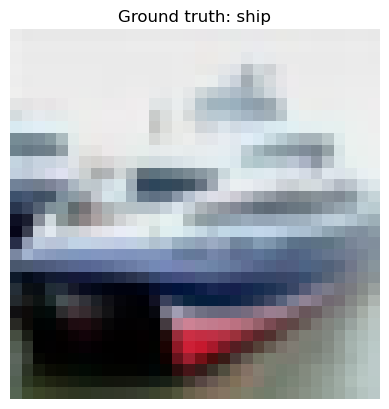

In [4]:
dataset_show_image(test_dset, 1)

## Model

In [5]:
def init_linear(m):
    if isinstance(m, (nn.Conv2d, nn.Linear)):
        nn.init.kaiming_normal_(m.weight)
        if m.bias is not None: nn.init.zeros_(m.bias)

model = Net(NUM_CLASSES, hidden_channels=64).to(DEVICE)
model.apply(init_linear)
print("Number of parameters: {:,}".format(sum(p.numel() for p in model.parameters())))

Number of parameters: 6,573,133


## Training

In [6]:
loss = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = optim.AdamW(model.parameters(), lr=1e-6, weight_decay=WEIGHT_DECAY)
lr_scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=LEARNING_RATE,
                                             steps_per_epoch=len(train_loader), epochs=EPOCHS)

In [7]:
try:
    history = []
    for epoch in range(EPOCHS):
        model.train()
        train_loss, train_acc = 0., 0.
        for x, y in tqdm(train_loader):
            model.zero_grad()
            inputs = model(x.to(DEVICE))
            targets = y.to(DEVICE)
            batch_loss = loss(inputs, targets)
            batch_loss.backward()
            optimizer.step()
            lr_scheduler.step()
            with torch.no_grad():
                batch_acc = torch.sum(torch.argmax(inputs, dim=1) == targets) / len(targets)
            train_loss += batch_loss.item() / len(train_loader)
            train_acc += batch_acc.item() / len(train_loader)
        
        model.eval()
        with torch.no_grad():
            val_loss, val_acc = 0., 0.
            for x, y in test_loader:
                inputs = model(x.to(DEVICE))
                targets = y.to(DEVICE)
                batch_loss = loss(inputs, targets)
                batch_acc = torch.sum(torch.argmax(inputs, dim=1) == targets) / len(targets)
                val_loss += batch_loss.item() / len(test_loader)
                val_acc += batch_acc.item() / len(test_loader)

        print("{}/{} - train: loss {:.3f}; val: loss {:.3f} accuracy {:.3f}".format(
            epoch + 1, EPOCHS, train_loss, val_loss, val_acc))
        history.append({
            "epoch": epoch,
            "train_loss": train_loss,
            "train_acc": train_acc,
            "val_loss": val_loss,
            "val_acc": val_acc
        })

except KeyboardInterrupt:
    print("Graceful Exit")

  0%|          | 0/98 [00:00<?, ?it/s]/home/ronak/.local/lib/python3.10/site-packages/torch/nn/modules/conv.py:456: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,
100%|██████████| 98/98 [00:19<00:00,  5.02it/s]


1/20 - train: loss 1.804; val: loss 1.449 accuracy 0.577


100%|██████████| 98/98 [00:19<00:00,  5.02it/s]


2/20 - train: loss 1.325; val: loss 1.439 accuracy 0.613


100%|██████████| 98/98 [00:19<00:00,  5.00it/s]


3/20 - train: loss 1.119; val: loss 1.270 accuracy 0.666


100%|██████████| 98/98 [00:19<00:00,  4.98it/s]


4/20 - train: loss 1.034; val: loss 1.064 accuracy 0.770


100%|██████████| 98/98 [00:19<00:00,  4.96it/s]


5/20 - train: loss 0.959; val: loss 0.968 accuracy 0.816


100%|██████████| 98/98 [00:19<00:00,  4.98it/s]


6/20 - train: loss 0.899; val: loss 1.288 accuracy 0.671


100%|██████████| 98/98 [00:19<00:00,  4.96it/s]


7/20 - train: loss 0.840; val: loss 0.895 accuracy 0.847


100%|██████████| 98/98 [00:19<00:00,  4.97it/s]


8/20 - train: loss 0.806; val: loss 0.854 accuracy 0.865


100%|██████████| 98/98 [00:19<00:00,  5.00it/s]


9/20 - train: loss 0.767; val: loss 0.900 accuracy 0.849


100%|██████████| 98/98 [00:19<00:00,  4.97it/s]


10/20 - train: loss 0.737; val: loss 0.819 accuracy 0.879


100%|██████████| 98/98 [00:19<00:00,  5.01it/s]


11/20 - train: loss 0.710; val: loss 0.782 accuracy 0.896


100%|██████████| 98/98 [00:19<00:00,  5.02it/s]


12/20 - train: loss 0.682; val: loss 0.786 accuracy 0.893


100%|██████████| 98/98 [00:19<00:00,  4.99it/s]


13/20 - train: loss 0.654; val: loss 0.753 accuracy 0.903


100%|██████████| 98/98 [00:19<00:00,  4.98it/s]


14/20 - train: loss 0.632; val: loss 0.721 accuracy 0.917


100%|██████████| 98/98 [00:19<00:00,  4.96it/s]


15/20 - train: loss 0.613; val: loss 0.704 accuracy 0.924


100%|██████████| 98/98 [00:19<00:00,  4.96it/s]


16/20 - train: loss 0.597; val: loss 0.697 accuracy 0.927


100%|██████████| 98/98 [00:19<00:00,  5.04it/s]


17/20 - train: loss 0.584; val: loss 0.688 accuracy 0.930


100%|██████████| 98/98 [00:19<00:00,  5.04it/s]


18/20 - train: loss 0.573; val: loss 0.680 accuracy 0.933


100%|██████████| 98/98 [00:19<00:00,  5.08it/s]


19/20 - train: loss 0.570; val: loss 0.680 accuracy 0.933


100%|██████████| 98/98 [00:19<00:00,  5.07it/s]


20/20 - train: loss 0.569; val: loss 0.680 accuracy 0.933


In [ ]:
path = "/mnt/ssd/ronak/output/cifar10c/erm_model.pt"
torch.save(model.state_dict(), path)

## In-Distribution Evaluation

In [ ]:
path = "/mnt/ssd/ronak/output/cifar10c/erm_model.pt"

model = Net(NUM_CLASSES, hidden_channels=64).to(DEVICE)
model.load_state_dict(torch.load(path))
model.eval()

## Out-of-Distribution Evaluation